<a href="https://colab.research.google.com/github/bettytan123/Sample-Size-Calculation/blob/main/Python_SampleSize_ConfidenceInterval_ContinuousMean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
############################################
## This script will simulate data from known statistical distirbutions; then estimate GAN and sample from it
##
## Authors: Betty and Chris
## Date: February 2023
############################################

In [ ]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv --quiet
! pip install --upgrade scipy --quiet
! pip install sinfo --quiet
! pip install matplotlib==3.1.3 --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 63.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.0
    Uninstalling matplotlib-3.7.0:
      Successfully uninstalled matplotlib-3.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
copulas 0.8.0 requires matplotlib<4,>=3.4.0; python_version >= "3.7" and python_version < "3.10", but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function 
import scipy

## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU 
import torch

import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style('darkgrid')


In [ ]:
## Set seed 
random.seed(12345)

In [ ]:
#####################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by Mathemtical Theory
##
#####################################

In [ ]:
scipy.stats.norm.ppf(q=0.025, loc=0, scale=1)

-1.9599639845400545

In [ ]:
## Sample size by math
def samp_size_cont_ci(alpha, width, sigma):
    n = (4 * (scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)**2) * (sigma**2) ) / (width**2)
    return n 

In [ ]:
samp_size_cont_ci(alpha=0.05, width=0.6, sigma=1) # 42.68288

42.6828757854903

In [ ]:
#################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by numerical simulation
##
################################

In [ ]:
def norm_ci_samp_size(n, mean, sd):
    ## Generate random data
    x = np.random.normal(loc=mean, scale = sd, size=n)
    ## Analyze generated/simulated data
    res = scipy.stats.ttest_1samp(x, popmean=mean, axis=0, 
                        nan_policy='propagate', 
                        alternative='two-sided')
    
    ## Extract the estimate and CI
    mu_ll, mu_ul = res.confidence_interval(0.95)
    mu_hat = np.mean(x)
    
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'mean': [mu_hat],
                        'll95_mean': [mu_ll],
                        'ul95_mean': [mu_ul]})
    
    return(out)


In [ ]:
## Replicate above function number of simulation replicate times

# parameter available  
n = int(np.ceil(samp_size_cont_ci(alpha=0.05, width=0.6, sigma=1)))
mean = 0
sd = 1

## Number simulation replicates
n_rep = 10000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(norm_ci_samp_size(n=n, mean=mean, sd=sd))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate means of each column in the array #axis means column mean 
sim_means = np.mean(sim_df, axis=0)

#Calculate the width of the confidence interval
ci_width = sim_means[2] - sim_means[1]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    'mean_hat': [sim_means[0]],
    'mean_ll95': [sim_means[1]],
    'mean_ul95': [sim_means[2]],
    'ci_width': [ci_width]
})

sim_results

,runtime,mean_hat,mean_ll95,mean_ul95,ci_width
0,23.759706,0.001052,-0.30504,0.307144,0.612183


In [ ]:
#############################################################
##
## Sample size estimation by GAN simulation
##
#############################################################

In [ ]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_normal(pop_mu, pop_sd, pop_n):

    ## Simulate data as input to GAN
    x = np.random.normal(loc=pop_mu, scale=pop_sd, size=pop_n)

    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({"x": x})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=True)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out

In [ ]:
## Parameters of normal parent distribution
mu = 0
sd = 1 
n = 10000

## Get the learned GAN model --- after training 
t0 = time()
train_gan = train_gan_model_normal(pop_mu=mu, pop_sd=sd, pop_n=n)
t1 = time()
fit_time = t1 - t0
fit_time

Epoch 1, Loss G: -0.1241,Loss D:  0.0764
Epoch 2, Loss G: -0.0947,Loss D:  0.0836
Epoch 3, Loss G: -0.1259,Loss D:  0.1238
Epoch 4, Loss G:  0.2225,Loss D: -0.3918
Epoch 5, Loss G: -0.0678,Loss D: -0.0406
Epoch 6, Loss G: -0.0731,Loss D: -0.0127
Epoch 7, Loss G: -0.3944,Loss D:  0.2808
Epoch 8, Loss G: -0.2720,Loss D:  0.1212
Epoch 9, Loss G: -0.0064,Loss D: -0.1683
Epoch 10, Loss G: -0.1057,Loss D: -0.2261
Epoch 11, Loss G: -0.3374,Loss D:  0.0254
Epoch 12, Loss G: -0.2952,Loss D:  0.1562
Epoch 13, Loss G: -0.3703,Loss D:  0.0295
Epoch 14, Loss G: -0.2913,Loss D: -0.0608
Epoch 15, Loss G: -0.3573,Loss D: -0.0863
Epoch 16, Loss G: -0.3594,Loss D:  0.0163
Epoch 17, Loss G: -0.3367,Loss D: -0.0926
Epoch 18, Loss G: -0.3983,Loss D:  0.0048
Epoch 19, Loss G: -0.3996,Loss D:  0.0550
Epoch 20, Loss G: -0.3675,Loss D: -0.0254
Epoch 21, Loss G: -0.4054,Loss D: -0.0096
Epoch 22, Loss G: -0.4618,Loss D: -0.0652
Epoch 23, Loss G: -0.3833,Loss D: -0.0779
Epoch 24, Loss G: -0.4269,Loss D:  0.0006
E

91.78001165390015

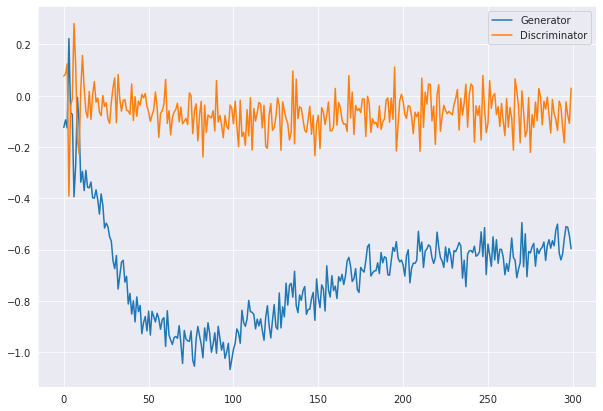

In [ ]:
logs = """
Epoch 1, Loss G: -0.1241,Loss D:  0.0764
Epoch 2, Loss G: -0.0947,Loss D:  0.0836
Epoch 3, Loss G: -0.1259,Loss D:  0.1238
Epoch 4, Loss G:  0.2225,Loss D: -0.3918
Epoch 5, Loss G: -0.0678,Loss D: -0.0406
Epoch 6, Loss G: -0.0731,Loss D: -0.0127
Epoch 7, Loss G: -0.3944,Loss D:  0.2808
Epoch 8, Loss G: -0.2720,Loss D:  0.1212
Epoch 9, Loss G: -0.0064,Loss D: -0.1683
Epoch 10, Loss G: -0.1057,Loss D: -0.2261
Epoch 11, Loss G: -0.3374,Loss D:  0.0254
Epoch 12, Loss G: -0.2952,Loss D:  0.1562
Epoch 13, Loss G: -0.3703,Loss D:  0.0295
Epoch 14, Loss G: -0.2913,Loss D: -0.0608
Epoch 15, Loss G: -0.3573,Loss D: -0.0863
Epoch 16, Loss G: -0.3594,Loss D:  0.0163
Epoch 17, Loss G: -0.3367,Loss D: -0.0926
Epoch 18, Loss G: -0.3983,Loss D:  0.0048
Epoch 19, Loss G: -0.3996,Loss D:  0.0550
Epoch 20, Loss G: -0.3675,Loss D: -0.0254
Epoch 21, Loss G: -0.4054,Loss D: -0.0096
Epoch 22, Loss G: -0.4618,Loss D: -0.0652
Epoch 23, Loss G: -0.3833,Loss D: -0.0779
Epoch 24, Loss G: -0.4269,Loss D:  0.0006
Epoch 25, Loss G: -0.5164,Loss D: -0.0424
Epoch 26, Loss G: -0.4971,Loss D: -0.0279
Epoch 27, Loss G: -0.5111,Loss D: -0.0911
Epoch 28, Loss G: -0.5502,Loss D: -0.1081
Epoch 29, Loss G: -0.5679,Loss D: -0.0262
Epoch 30, Loss G: -0.6437,Loss D:  0.0311
Epoch 31, Loss G: -0.6746,Loss D:  0.0694
Epoch 32, Loss G: -0.6232,Loss D: -0.1059
Epoch 33, Loss G: -0.7541,Loss D:  0.0824
Epoch 34, Loss G: -0.7031,Loss D: -0.0133
Epoch 35, Loss G: -0.6492,Loss D: -0.0606
Epoch 36, Loss G: -0.6420,Loss D: -0.0190
Epoch 37, Loss G: -0.7270,Loss D: -0.0153
Epoch 38, Loss G: -0.7044,Loss D: -0.0571
Epoch 39, Loss G: -0.8126,Loss D: -0.0602
Epoch 40, Loss G: -0.7712,Loss D: -0.0730
Epoch 41, Loss G: -0.8515,Loss D:  0.0453
Epoch 42, Loss G: -0.8000,Loss D: -0.0971
Epoch 43, Loss G: -0.8821,Loss D: -0.0045
Epoch 44, Loss G: -0.7847,Loss D: -0.0804
Epoch 45, Loss G: -0.8423,Loss D: -0.0214
Epoch 46, Loss G: -0.8181,Loss D: -0.0369
Epoch 47, Loss G: -0.9282,Loss D:  0.0051
Epoch 48, Loss G: -0.8848,Loss D: -0.0085
Epoch 49, Loss G: -0.8611,Loss D:  0.0081
Epoch 50, Loss G: -0.9173,Loss D: -0.0409
Epoch 51, Loss G: -0.8403,Loss D: -0.0630
Epoch 52, Loss G: -0.9338,Loss D: -0.1008
Epoch 53, Loss G: -0.8408,Loss D: -0.0764
Epoch 54, Loss G: -0.8617,Loss D: -0.0550
Epoch 55, Loss G: -0.8825,Loss D:  0.0139
Epoch 56, Loss G: -0.8484,Loss D: -0.0459
Epoch 57, Loss G: -0.8692,Loss D: -0.1627
Epoch 58, Loss G: -0.9110,Loss D: -0.0699
Epoch 59, Loss G: -0.8742,Loss D: -0.0586
Epoch 60, Loss G: -0.8653,Loss D: -0.0334
Epoch 61, Loss G: -0.9775,Loss D:  0.0627
Epoch 62, Loss G: -0.8387,Loss D: -0.1084
Epoch 63, Loss G: -0.9333,Loss D: -0.0588
Epoch 64, Loss G: -0.9535,Loss D: -0.1529
Epoch 65, Loss G: -0.9701,Loss D: -0.0848
Epoch 66, Loss G: -0.9428,Loss D: -0.0648
Epoch 67, Loss G: -0.9390,Loss D: -0.0537
Epoch 68, Loss G: -0.9461,Loss D: -0.0297
Epoch 69, Loss G: -0.8967,Loss D: -0.1021
Epoch 70, Loss G: -0.9654,Loss D: -0.0449
Epoch 71, Loss G: -1.0441,Loss D: -0.1099
Epoch 72, Loss G: -0.9154,Loss D: -0.1000
Epoch 73, Loss G: -0.9490,Loss D: -0.0887
Epoch 74, Loss G: -0.9555,Loss D: -0.1125
Epoch 75, Loss G: -0.9581,Loss D:  0.0107
Epoch 76, Loss G: -0.9173,Loss D: -0.0006
Epoch 77, Loss G: -1.0316,Loss D: -0.1484
Epoch 78, Loss G: -1.0550,Loss D: -0.0585
Epoch 79, Loss G: -0.9491,Loss D: -0.0321
Epoch 80, Loss G: -0.8998,Loss D: -0.1767
Epoch 81, Loss G: -0.9358,Loss D: -0.0753
Epoch 82, Loss G: -0.9694,Loss D: -0.0225
Epoch 83, Loss G: -1.0219,Loss D: -0.2392
Epoch 84, Loss G: -0.9057,Loss D: -0.0374
Epoch 85, Loss G: -0.9560,Loss D: -0.1427
Epoch 86, Loss G: -0.8857,Loss D: -0.0753
Epoch 87, Loss G: -0.9280,Loss D: -0.0820
Epoch 88, Loss G: -1.0003,Loss D: -0.0874
Epoch 89, Loss G: -0.9689,Loss D: -0.0588
Epoch 90, Loss G: -0.9246,Loss D: -0.1380
Epoch 91, Loss G: -1.0045,Loss D:  0.0583
Epoch 92, Loss G: -0.8994,Loss D: -0.1029
Epoch 93, Loss G: -0.9453,Loss D: -0.0771
Epoch 94, Loss G: -0.9922,Loss D: -0.1140
Epoch 95, Loss G: -0.9616,Loss D: -0.1641
Epoch 96, Loss G: -1.0244,Loss D: -0.0773
Epoch 97, Loss G: -1.0000,Loss D: -0.1191
Epoch 98, Loss G: -0.9658,Loss D: -0.1308
Epoch 99, Loss G: -1.0677,Loss D: -0.0368
Epoch 100, Loss G: -1.0274,Loss D: -0.0493
Epoch 101, Loss G: -0.9888,Loss D: -0.1102
Epoch 102, Loss G: -0.9658,Loss D: -0.0214
Epoch 103, Loss G: -0.9097,Loss D: -0.1176
Epoch 104, Loss G: -0.9244,Loss D: -0.1991
Epoch 105, Loss G: -0.9655,Loss D: -0.0180
Epoch 106, Loss G: -0.8367,Loss D: -0.1595
Epoch 107, Loss G: -0.8846,Loss D: -0.1432
Epoch 108, Loss G: -0.8994,Loss D: -0.1939
Epoch 109, Loss G: -0.8708,Loss D: -0.0547
Epoch 110, Loss G: -0.7984,Loss D: -0.1572
Epoch 111, Loss G: -0.8420,Loss D: -0.0084
Epoch 112, Loss G: -0.8449,Loss D: -0.2121
Epoch 113, Loss G: -0.8532,Loss D: -0.0497
Epoch 114, Loss G: -0.9093,Loss D: -0.0992
Epoch 115, Loss G: -0.8713,Loss D: -0.0668
Epoch 116, Loss G: -0.8977,Loss D: -0.0265
Epoch 117, Loss G: -0.8701,Loss D: -0.0332
Epoch 118, Loss G: -0.9154,Loss D: -0.1261
Epoch 119, Loss G: -0.9537,Loss D: -0.0379
Epoch 120, Loss G: -0.8648,Loss D: -0.1984
Epoch 121, Loss G: -0.8189,Loss D: -0.2050
Epoch 122, Loss G: -0.8950,Loss D: -0.0765
Epoch 123, Loss G: -0.9446,Loss D: -0.0312
Epoch 124, Loss G: -0.8755,Loss D: -0.1353
Epoch 125, Loss G: -0.8149,Loss D: -0.1249
Epoch 126, Loss G: -0.9008,Loss D: -0.0841
Epoch 127, Loss G: -0.9111,Loss D: -0.0090
Epoch 128, Loss G: -0.7693,Loss D: -0.0390
Epoch 129, Loss G: -0.9053,Loss D: -0.2132
Epoch 130, Loss G: -0.8232,Loss D: -0.0240
Epoch 131, Loss G: -0.8622,Loss D: -0.0607
Epoch 132, Loss G: -0.7314,Loss D: -0.0885
Epoch 133, Loss G: -0.8165,Loss D: -0.1088
Epoch 134, Loss G: -0.7388,Loss D: -0.1728
Epoch 135, Loss G: -0.7319,Loss D: -0.1430
Epoch 136, Loss G: -0.7857,Loss D:  0.0960
Epoch 137, Loss G: -0.6845,Loss D: -0.1880
Epoch 138, Loss G: -0.8181,Loss D:  0.0643
Epoch 139, Loss G: -0.8463,Loss D: -0.0894
Epoch 140, Loss G: -0.7771,Loss D: -0.0432
Epoch 141, Loss G: -0.7981,Loss D: -0.0489
Epoch 142, Loss G: -0.7600,Loss D: -0.0937
Epoch 143, Loss G: -0.7439,Loss D: -0.1350
Epoch 144, Loss G: -0.8528,Loss D: -0.1431
Epoch 145, Loss G: -0.8339,Loss D: -0.0941
Epoch 146, Loss G: -0.8323,Loss D: -0.0417
Epoch 147, Loss G: -0.7914,Loss D: -0.1507
Epoch 148, Loss G: -0.7671,Loss D: -0.0769
Epoch 149, Loss G: -0.8758,Loss D: -0.2337
Epoch 150, Loss G: -0.7144,Loss D: -0.1105
Epoch 151, Loss G: -0.7869,Loss D: -0.0771
Epoch 152, Loss G: -0.8267,Loss D: -0.2066
Epoch 153, Loss G: -0.7379,Loss D: -0.0465
Epoch 154, Loss G: -0.7538,Loss D: -0.0644
Epoch 155, Loss G: -0.8396,Loss D: -0.1128
Epoch 156, Loss G: -0.6636,Loss D: -0.0752
Epoch 157, Loss G: -0.7577,Loss D: -0.0252
Epoch 158, Loss G: -0.7851,Loss D: -0.1375
Epoch 159, Loss G: -0.7019,Loss D: -0.1368
Epoch 160, Loss G: -0.7604,Loss D: -0.1210
Epoch 161, Loss G: -0.7427,Loss D:  0.0280
Epoch 162, Loss G: -0.7910,Loss D: -0.1155
Epoch 163, Loss G: -0.7060,Loss D: -0.0267
Epoch 164, Loss G: -0.7232,Loss D: -0.0469
Epoch 165, Loss G: -0.6969,Loss D: -0.0953
Epoch 166, Loss G: -0.7367,Loss D: -0.1119
Epoch 167, Loss G: -0.7035,Loss D: -0.1097
Epoch 168, Loss G: -0.6455,Loss D: -0.1398
Epoch 169, Loss G: -0.6305,Loss D:  0.0782
Epoch 170, Loss G: -0.6641,Loss D: -0.0878
Epoch 171, Loss G: -0.7246,Loss D:  0.0137
Epoch 172, Loss G: -0.7137,Loss D: -0.1514
Epoch 173, Loss G: -0.6745,Loss D: -0.0381
Epoch 174, Loss G: -0.7558,Loss D: -0.0583
Epoch 175, Loss G: -0.7676,Loss D: -0.0504
Epoch 176, Loss G: -0.6696,Loss D: -0.0665
Epoch 177, Loss G: -0.6805,Loss D: -0.0129
Epoch 178, Loss G: -0.6879,Loss D: -0.0128
Epoch 179, Loss G: -0.6434,Loss D: -0.1595
Epoch 180, Loss G: -0.5895,Loss D: -0.0029
Epoch 181, Loss G: -0.5796,Loss D: -0.0305
Epoch 182, Loss G: -0.7033,Loss D: -0.1433
Epoch 183, Loss G: -0.6912,Loss D: -0.0903
Epoch 184, Loss G: -0.6836,Loss D: -0.1094
Epoch 185, Loss G: -0.6821,Loss D: -0.1037
Epoch 186, Loss G: -0.6516,Loss D: -0.1250
Epoch 187, Loss G: -0.6935,Loss D: -0.0402
Epoch 188, Loss G: -0.6118,Loss D: -0.1316
Epoch 189, Loss G: -0.6517,Loss D: -0.1022
Epoch 190, Loss G: -0.6280,Loss D: -0.0911
Epoch 191, Loss G: -0.6327,Loss D: -0.0176
Epoch 192, Loss G: -0.6986,Loss D: -0.0092
Epoch 193, Loss G: -0.7001,Loss D: -0.1037
Epoch 194, Loss G: -0.6429,Loss D: -0.0096
Epoch 195, Loss G: -0.5919,Loss D: -0.0926
Epoch 196, Loss G: -0.6069,Loss D:  0.1110
Epoch 197, Loss G: -0.5692,Loss D: -0.2155
Epoch 198, Loss G: -0.6330,Loss D: -0.1197
Epoch 199, Loss G: -0.6481,Loss D: -0.0200
Epoch 200, Loss G: -0.6411,Loss D:  0.0051
Epoch 201, Loss G: -0.6601,Loss D: -0.0222
Epoch 202, Loss G: -0.7037,Loss D: -0.0741
Epoch 203, Loss G: -0.6241,Loss D: -0.0888
Epoch 204, Loss G: -0.6011,Loss D: -0.0388
Epoch 205, Loss G: -0.7298,Loss D: -0.0428
Epoch 206, Loss G: -0.6721,Loss D: -0.0817
Epoch 207, Loss G: -0.6533,Loss D: -0.1484
Epoch 208, Loss G: -0.6539,Loss D: -0.0651
Epoch 209, Loss G: -0.6425,Loss D: -0.0826
Epoch 210, Loss G: -0.5287,Loss D: -0.0647
Epoch 211, Loss G: -0.6070,Loss D: -0.2170
Epoch 212, Loss G: -0.5708,Loss D:  0.0679
Epoch 213, Loss G: -0.6699,Loss D: -0.1235
Epoch 214, Loss G: -0.6062,Loss D:  0.0135
Epoch 215, Loss G: -0.5978,Loss D: -0.0335
Epoch 216, Loss G: -0.5817,Loss D:  0.0453
Epoch 217, Loss G: -0.5885,Loss D:  0.0437
Epoch 218, Loss G: -0.6315,Loss D: -0.0987
Epoch 219, Loss G: -0.6541,Loss D: -0.0409
Epoch 220, Loss G: -0.6318,Loss D: -0.1900
Epoch 221, Loss G: -0.5322,Loss D:  0.0024
Epoch 222, Loss G: -0.5907,Loss D:  0.0429
Epoch 223, Loss G: -0.6315,Loss D: -0.1390
Epoch 224, Loss G: -0.6452,Loss D: -0.0802
Epoch 225, Loss G: -0.6696,Loss D: -0.0381
Epoch 226, Loss G: -0.5898,Loss D: -0.0578
Epoch 227, Loss G: -0.6480,Loss D: -0.0707
Epoch 228, Loss G: -0.5957,Loss D: -0.0616
Epoch 229, Loss G: -0.6222,Loss D: -0.0680
Epoch 230, Loss G: -0.6730,Loss D: -0.0751
Epoch 231, Loss G: -0.6039,Loss D: -0.0354
Epoch 232, Loss G: -0.6082,Loss D: -0.0113
Epoch 233, Loss G: -0.5929,Loss D:  0.0239
Epoch 234, Loss G: -0.5728,Loss D: -0.1344
Epoch 235, Loss G: -0.5856,Loss D: -0.0106
Epoch 236, Loss G: -0.7114,Loss D: -0.0759
Epoch 237, Loss G: -0.6416,Loss D: -0.0270
Epoch 238, Loss G: -0.7450,Loss D:  0.0444
Epoch 239, Loss G: -0.6184,Loss D: -0.1228
Epoch 240, Loss G: -0.6047,Loss D:  0.0051
Epoch 241, Loss G: -0.6040,Loss D:  0.0454
Epoch 242, Loss G: -0.6120,Loss D:  0.0359
Epoch 243, Loss G: -0.5869,Loss D: -0.1809
Epoch 244, Loss G: -0.6263,Loss D: -0.0395
Epoch 245, Loss G: -0.6209,Loss D: -0.0773
Epoch 246, Loss G: -0.6090,Loss D: -0.0397
Epoch 247, Loss G: -0.5309,Loss D: -0.1739
Epoch 248, Loss G: -0.6275,Loss D:  0.0786
Epoch 249, Loss G: -0.5146,Loss D: -0.0538
Epoch 250, Loss G: -0.6975,Loss D: -0.1440
Epoch 251, Loss G: -0.5787,Loss D: -0.1087
Epoch 252, Loss G: -0.6201,Loss D:  0.0581
Epoch 253, Loss G: -0.6655,Loss D: -0.0497
Epoch 254, Loss G: -0.5504,Loss D: -0.0024
Epoch 255, Loss G: -0.6405,Loss D:  0.0080
Epoch 256, Loss G: -0.5618,Loss D: -0.0742
Epoch 257, Loss G: -0.6537,Loss D: -0.0435
Epoch 258, Loss G: -0.5990,Loss D: -0.1199
Epoch 259, Loss G: -0.5996,Loss D: -0.0307
Epoch 260, Loss G: -0.6293,Loss D: -0.0988
Epoch 261, Loss G: -0.6983,Loss D: -0.1561
Epoch 262, Loss G: -0.6550,Loss D: -0.0116
Epoch 263, Loss G: -0.6851,Loss D: -0.1229
Epoch 264, Loss G: -0.6347,Loss D: -0.0461
Epoch 265, Loss G: -0.5550,Loss D: -0.0884
Epoch 266, Loss G: -0.6309,Loss D: -0.2124
Epoch 267, Loss G: -0.6418,Loss D:  0.0653
Epoch 268, Loss G: -0.7097,Loss D:  0.0185
Epoch 269, Loss G: -0.6770,Loss D: -0.0400
Epoch 270, Loss G: -0.6513,Loss D: -0.1840
Epoch 271, Loss G: -0.4950,Loss D:  0.0186
Epoch 272, Loss G: -0.6674,Loss D: -0.0611
Epoch 273, Loss G: -0.5385,Loss D: -0.1610
Epoch 274, Loss G: -0.7059,Loss D: -0.1382
Epoch 275, Loss G: -0.6076,Loss D: -0.0076
Epoch 276, Loss G: -0.6134,Loss D: -0.2214
Epoch 277, Loss G: -0.5896,Loss D: -0.0743
Epoch 278, Loss G: -0.5760,Loss D: -0.1237
Epoch 279, Loss G: -0.6650,Loss D: -0.0247
Epoch 280, Loss G: -0.5957,Loss D: -0.0979
Epoch 281, Loss G: -0.6159,Loss D:  0.0274
Epoch 282, Loss G: -0.5993,Loss D: -0.0043
Epoch 283, Loss G: -0.5907,Loss D: -0.1142
Epoch 284, Loss G: -0.5706,Loss D: -0.0218
Epoch 285, Loss G: -0.6424,Loss D: -0.0525
Epoch 286, Loss G: -0.5839,Loss D: -0.0058
Epoch 287, Loss G: -0.5618,Loss D: -0.0764
Epoch 288, Loss G: -0.5947,Loss D: -0.1462
Epoch 289, Loss G: -0.5653,Loss D: -0.0148
Epoch 290, Loss G: -0.5853,Loss D: -0.0699
Epoch 291, Loss G: -0.5240,Loss D: -0.0924
Epoch 292, Loss G: -0.5008,Loss D: -0.1360
Epoch 293, Loss G: -0.6137,Loss D: -0.0216
Epoch 294, Loss G: -0.6405,Loss D: -0.0407
Epoch 295, Loss G: -0.6176,Loss D: -0.1231
Epoch 296, Loss G: -0.5579,Loss D: -0.1837
Epoch 297, Loss G: -0.5106,Loss D: -0.0242
Epoch 298, Loss G: -0.5132,Loss D: -0.0748
Epoch 299, Loss G: -0.5454,Loss D: -0.1085
Epoch 300, Loss G: -0.5969,Loss D:  0.0289
"""

logs = logs.split('\n')[1:-1]
logs = [log.split(',') for log in logs]

loss_generator = [float(log[1].split(':')[1].strip()) for log in logs]
loss_discriminator = [float(log[2].split(':')[1].strip()) for log in logs]

plt.figure(figsize=(10,7))

plt.plot(loss_generator, label="Generator")
plt.plot(loss_discriminator, label="Discriminator")

plt.legend()
plt.show()

In [ ]:
model_ = train_gan[0]

In [ ]:
model_.get_parameters

<bound method BaseTabularModel.get_parameters of <sdv.tabular.ctgan.CTGAN object at 0x7fa2c31e7430>>

In [ ]:
## Summarize moments of the "parent distribution" used to simulate the synthetic GAN data
x_parent = train_gan[1]

x_parent.describe()

,x
count,10000.000000
mean,-0.000329
std,0.985811
min,-4.088495
25%,-0.663799
50%,-0.001023
75%,0.646108
max,3.818175


In [ ]:
## Parameter for specifying size of the simulated/synthetic data generated from the GAN
sim_n = int(np.ceil(samp_size_cont_ci(alpha=0.05, width=0.6, sigma=1)))

In [ ]:
## Function to analyze data from the sampled model 
def norm_ci_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    x = m.sample(num_rows=sim_n)
    ## Analyze generated/simulated data
    res = scipy.stats.ttest_1samp(x, popmean=mu, axis=0, nan_policy='propagate', alternative='two-sided')
    
    ## Extract the estimate and CI
    mu_ll, mu_ul = res.confidence_interval(0.95)
    mu_hat = np.mean(x)
    
    # Return the estimate and the CI to the user
    out = pd.DataFrame({'mean': [mu_hat],
                         'll95_mean': [mu_ll],
                         'ul95_mean': [mu_ul]})
    return(out)

In [ ]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(norm_ci_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean 
gan_means = np.mean(gan_df, axis=0)

## Calculate the width of the confidence interval
gan_width = gan_means[2] - gan_means[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'mean_hat': [gan_means[0]],
    'mean_ll95': [gan_means[1]],
    'mean_ul95': [gan_means[2]],
    'ci_width': [gan_width]
})

gan_results

,runtime,mean_hat,mean_ll95,mean_ul95,ci_width
0,15.253933,0.025877,-0.247453,0.299206,0.546659


In [ ]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [ ]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

dictionary = {'alpha': [0.05], 
              'mu': [0.0],
              'sigma': [2**-1, 2**0, 2**1, 2**2, 2**3], 
              'width': [2**-2, 2**-1, 2**0, 2**1]}

param_df = expand_grid(dictionary)
param_df

,alpha,mu,sigma,width
0,0.05,0.0,0.5,0.25
1,0.05,0.0,0.5,0.50
2,0.05,0.0,0.5,1.00
3,0.05,0.0,0.5,2.00
4,0.05,0.0,1.0,0.25
5,0.05,0.0,1.0,0.50
6,0.05,0.0,1.0,1.00
7,0.05,0.0,1.0,2.00
8,0.05,0.0,2.0,0.25
9,0.05,0.0,2.0,0.50


In [ ]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_cont_ci(alpha=param_df.loc[i, 'alpha'], 
                          width=param_df.loc[i, 'width'],
                          sigma=param_df.loc[i, 'sigma'])
    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

samp_size_theory_df = pd.concat([param_df, pd.Series(samp_size_theory_list)], axis=1)
samp_size_theory_df.columns = ['alpha','mu','sigma','width','n_theory']
samp_size_theory_df

,alpha,mu,sigma,width,n_theory
0,0.05,0.0,0.5,0.25,62.0
1,0.05,0.0,0.5,0.50,16.0
2,0.05,0.0,0.5,1.00,4.0
3,0.05,0.0,0.5,2.00,1.0
4,0.05,0.0,1.0,0.25,246.0
5,0.05,0.0,1.0,0.50,62.0
6,0.05,0.0,1.0,1.00,16.0
7,0.05,0.0,1.0,2.00,4.0
8,0.05,0.0,2.0,0.25,984.0
9,0.05,0.0,2.0,0.50,246.0


In [ ]:
########################
## 2) Sample Size for Continuous CI by Simulation from Normal Distribution
########################

In [ ]:
def norm_ci_samp_size(n, mean, sd):
    ## Generate random data
    x = np.random.normal(loc=mean, scale = sd, size=n)
    ## Analyze generated/simulated data
    res = scipy.stats.ttest_1samp(x, popmean=mean, axis=0, 
                        nan_policy='propagate', 
                        alternative='two-sided')
    
    ## Extract the estimate and CI
    mu_ll, mu_ul = res.confidence_interval(0.95)
    mu_hat = np.mean(x)
    
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'mean': [mu_hat],
                        'll95_mean': [mu_ll],
                        'ul95_mean': [mu_ul]})
    
    return(out)


In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def norm_ci_samp_size_sim(n, mean, sd, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in range(0, n_rep):
        sim_out.append(norm_ci_samp_size(n=n, mean=mean, sd=sd))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array 
    sim_means = np.mean(sim_df, axis=0)

    ## Calculate the width of the confidence interval
    ci_width = sim_means[2] - sim_means[1]

    ## Return expect width 
    return ci_width

In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 10000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    ci_width = norm_ci_samp_size_sim(n=int(float(samp_size_theory_df.loc[i, 'n_theory'])), 
                          mean=samp_size_theory_df.loc[i, 'mu'],
                          sd=samp_size_theory_df.loc[i, 'sigma'],
                          n_rep=n_rep)
    ## Round to largest integer
    ci_width_ = str(np.round(ci_width,4))
    ## Append sample size to list
    samp_size_sim_list.append(ci_width_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
samp_size_sim_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_sim_list)], axis=1)
samp_size_sim_df.columns = ['alpha','mu','sigma','width','n_theory','ci_width_sim']
samp_size_sim_df

,alpha,mu,sigma,width,n_theory,ci_width_sim
0,0.05,0.0,0.5,0.25,62.0,0.2528
1,0.05,0.0,0.5,0.50,16.0,0.5244
2,0.05,0.0,0.5,1.00,4.0,1.4701
3,0.05,0.0,0.5,2.00,1.0,nan
4,0.05,0.0,1.0,0.25,246.0,0.2509
5,0.05,0.0,1.0,0.50,62.0,0.5056
6,0.05,0.0,1.0,1.00,16.0,1.0466
7,0.05,0.0,1.0,2.00,4.0,2.9127
8,0.05,0.0,2.0,0.25,984.0,0.2503
9,0.05,0.0,2.0,0.50,246.0,0.5016


In [ ]:
## Timing for the simulation experiments
sim_time

275.4752073287964

In [ ]:
########################
## 3) Sample Size for Continuous CI by Generative Adversarial Network (GAN) from a (parent) Normal Distribution
########################

In [ ]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_normal(pop_mu, pop_sd, pop_n):

    ## Simulate data as input to GAN
    x = np.random.normal(loc=pop_mu, scale=pop_sd, size=pop_n)

    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({"x": x})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN()

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out

In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def norm_ci_samp_size_gan(pop_n, pop_mu, pop_sd, sim_n, n_rep):

    ## Get the learned GAN model --- after training 
    t0 = time()
    train_gan = train_gan_model_normal(pop_mu=pop_mu, pop_sd=pop_sd, pop_n=pop_n)
    t1 = time()
    fit_time = t1 - t0
    #fit_time
    
    ## Extract learned GAN model
    model_ = train_gan[0]

    ## Function to analyze data from the sampled model 
    def norm_ci_samp_size_gan(m, sim_n):
        ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
        x = m.sample(num_rows=sim_n)
        ## Analyze generated/simulated data
        res = scipy.stats.ttest_1samp(x, popmean=mu, axis=0, nan_policy='propagate', alternative='two-sided')
    
        ## Extract the estimate and CI
        mu_ll, mu_ul = res.confidence_interval(0.95)
        mu_hat = np.mean(x)
 
        # Return the estimate and the CI to the user
        out = pd.DataFrame({'mean': [mu_hat],
                         'll95_mean': [mu_ll],
                         'ul95_mean': [mu_ul]})
        return(out)
    
    ##
    ## Replicate above function number of simulation replicate times
    ##

    ## Simulate n_rep copies of sample size trials
    gan_out = []
 
    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        gan_out.append(norm_ci_samp_size_gan(m=model_, sim_n=sim_n))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean 
    gan_means = np.mean(gan_df, axis=0)

    ## Calculate the width of the confidence interval
    gan_width = gan_means[2] - gan_means[1]

    ## Return the GAN estimated CI width
    return gan_width

In [ ]:
##
## WARNING...notice very subtle difference between pop_n and sim_n
##
## "sim_n" should be set to size of theoretical sample size needed to obtain CI of expected width, given SD/alpha/mean
##
## "pop_n" can vary...larger values mean GAN parent dist is more likely converge in dist to population model, smaller values reduce likelihood convergence in dist
##     --- larger values can also substantially increase training time for the GAN model
##

t0 = time()

tmp = norm_ci_samp_size_gan(pop_n=1000, 
                      pop_mu=0, 
                      pop_sd=1, 
                      sim_n=int(np.ceil(samp_size_cont_ci(alpha=0.05, width=0.6, sigma=1))),
                      n_rep=1000)

t1 = time()

[tmp, t1-t0]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0.5936664666076736, 30.572638750076294]

In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    ci_width = norm_ci_samp_size_gan(pop_n=1000, 
                      pop_mu=samp_size_theory_df.loc[i, 'mu'], 
                      pop_sd=samp_size_theory_df.loc[i, 'sigma'], 
                      sim_n=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
                      n_rep=n_rep)
    ## Round to largest integer
    ci_width_ = str(np.round(ci_width,4))
    ## Append sample size to list
    samp_size_gan_list.append(ci_width_)

t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
samp_size_gan_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_gan_list)], axis=1)
samp_size_gan_df.columns = ['alpha','mu','sigma','width','n_theory','ci_width_gan']
samp_size_gan_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,mu,sigma,width,n_theory,ci_width_gan
0,0.05,0.0,0.5,0.25,62.0,0.2919
1,0.05,0.0,0.5,0.50,16.0,0.5801
2,0.05,0.0,0.5,1.00,4.0,1.5981
3,0.05,0.0,0.5,2.00,1.0,nan
4,0.05,0.0,1.0,0.25,246.0,0.3552
5,0.05,0.0,1.0,0.50,62.0,0.4972
6,0.05,0.0,1.0,1.00,16.0,1.3663
7,0.05,0.0,1.0,2.00,4.0,3.6996
8,0.05,0.0,2.0,0.25,984.0,0.264
9,0.05,0.0,2.0,0.50,246.0,0.4987


In [ ]:
gan_time

702.6703052520752

In [ ]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [ ]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-02-23'

In [ ]:
## Session Info
from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
matplotlib  3.2.2
numpy       1.22.4
pandas      1.3.5
scipy       1.10.1
sdv         0.18.0
sinfo       0.3.4
torch       1.13.1+cu116
tqdm        4.64.1
-----
IPython             7.9.0
jupyter_client      6.1.12
jupyter_core        5.2.0
notebook            6.3.0
-----
Python 3.8.10 (default, Nov 14 2022, 12:59:47) [GCC 9.4.0]
Linux-5.10.147+-x86_64-with-glibc2.29
2 logical CPU cores, x86_64
-----
Session information updated at 2023-02-23 00:05


In [ ]:
## Jupyter version
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.9.0
ipykernel        : 5.3.4
ipywidgets       : 7.7.1
jupyter_client   : 6.1.12
jupyter_core     : 5.2.0
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : not installed
nbconvert        : 5.6.1
nbformat         : 5.7.3
notebook         : 6.3.0
qtconsole        : not installed
traitlets        : 5.7.1


In [ ]:
## Python version
!python --version

Python 3.8.10
